# Add Systematics
In this notebook we demo the subsampling approach to introduce systematics.

In [1]:
%matplotlib inline
import healpy as hp
import numpy as np
import fitsio as ft
import matplotlib.pyplot as plt

In [2]:
def radec2hpix(nside, ra, dec):
    """ change ra,dec to HEALPix hpix with ring ordering """
    theta, phi = np.deg2rad(90.-dec), np.deg2rad(ra)
    hpix = hp.ang2pix(nside, theta, phi, nest=False)     
    return hpix

def project2hp(nside, mock, weight=None):
    """ count # of objects in HEALPix """
    ra = mock['RA']
    dec = mock['DEC']
    hpix = radec2hpix(nside, ra, dec)
    return np.bincount(hpix, weights=weight, minlength=12*nside*nside)

def downsample(selection_func, mock):
    """ downsample a mock catalog with a given selection function """
    nside = hp.get_nside(selection_func)
    hpix = radec2hpix(nside, mock['RA'], mock['DEC'])
    prob = selection_func[hpix]    
    good = np.random.uniform(size=mock.size) < prob
    return mock[good]


# read the mock catalog and selection function (obtained from real data)
mock = ft.read('/home/mehdi/data/fortanveer/FA_EZmock_desi_ELG_v0_10.fits')
ngal_pred = hp.read_map('/home/mehdi/data/alternative/results_elg/regression/nn_p/nn-weights.hp256.fits', 
                        verbose=False)

# get nside from the selection function
nside = hp.get_nside(ngal_pred)

# normalize the selection function to [0, 1]
good = ngal_pred>0
vmin, vmax = np.percentile(ngal_pred[good], [0, 100])
selection_func = np.zeros_like(ngal_pred)
selection_func[good] = (ngal_pred[good]-vmin) / (vmax-vmin)

# subsample the mock catalog, and project to HEALPix
mock_after = downsample(selection_func, mock)
mock_hp = project2hp(nside, mock)
mock_hp_after = project2hp(nside, mock_after)

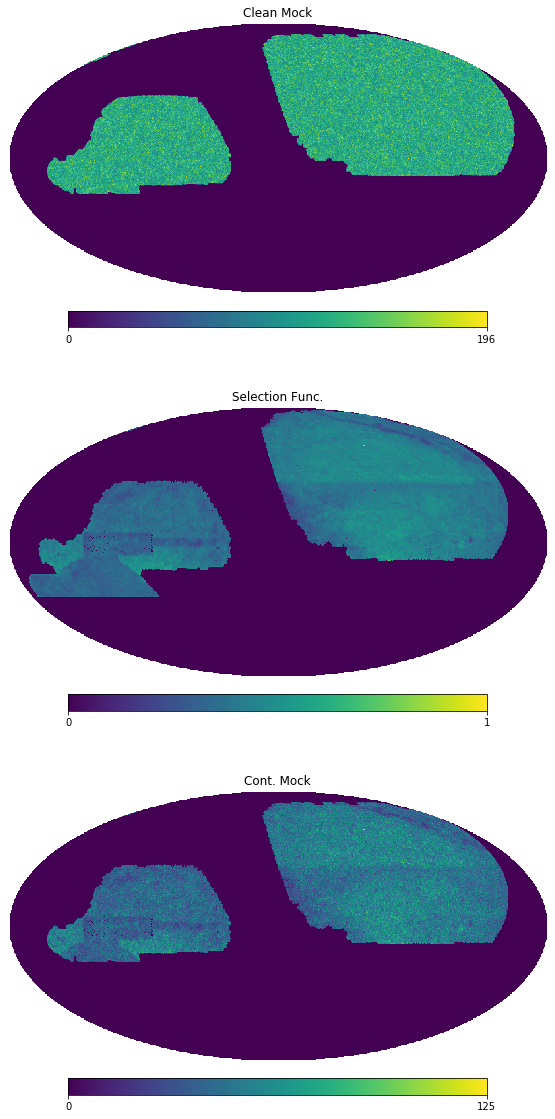

In [4]:
fig, ax = plt.subplots(nrows=3, figsize=(15, 20))

for i, (mapi, title) in enumerate(zip([mock_hp, selection_func, mock_hp_after],
                                      ['Clean Mock', 'Selection Func.', 'Cont. Mock'])):
    plt.sca(ax[i])
        
    hp.mollview(mapi, title=title, hold=True, rot=-85)